# Project: wrangle and analyze data
<br>
* ### [Preliminary steps](#preliminary)
* ### [Gathering data](#gather)
* ### [Assessing data](#assess)
* ### [Cleaning data](#clean)
* ### [Storing, analyzing, and visualizing data](#store)

<br>
In this Jupyter notebook I will wrangle (gather, assess, and clean) data about tweets by WeRateDogs Twitter account as well as performing some basic analysis and visualization of it.

<a id = 'preliminary'></a>

## Preliminary steps

Before starting to wrangle it's necessary to import a couple of Python libraries: pandas and NumPy for data handling, Requests for loading data from www pages, json for handling tweet information, and tweepy for Twitter access. Also, the API object for accessing Twitter data needs to be set up.

In [1]:
# importing the necessary libraries

import pandas as pd
import numpy as np

import requests
import json

In [2]:
# importing tweepy and setting up
# the API object for Twitter access

import tweepy


consumer_key = 'my_consumer_key'
consumer_secret = 'my_consumer_secret'
access_token = 'my_access_token'
access_secret = 'my_access_secret'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

<a id = 'gather'></a>

## Gathering data

There are three sources the data needs to be gathered from: two flat files on the cloud site used by Udacity and Tweet information gathered directly from Twitter using tweepy. Downloading and saving the flat files is pretty straightforward procedure, while gathering data from Twitter requires a bit more work.

In [3]:
# downloading the two flat files

r1 = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

with open('image-predictions.tsv', mode = 'wb') as file:
    file.write(r1.content)
    
r2 = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv')

with open('twitter-archive-enhanced.csv', mode = 'wb') as file:
    file.write(r2.content)

In [4]:
# reading data from the flat files into dataframes

df_tweets = pd.read_csv('twitter-archive-enhanced.csv')

df_preds = pd.read_csv('image-predictions.tsv', sep = '\t')

In [5]:
# fetching json data for dog_rate tweets
# by iterating through the tweet_id column
# of the tweet dataframe, writing the
# data into a .txt file; tweet ids rising
# errors stored into a list for further
# perusal

error_ids = []

for _ in df_tweets.tweet_id:
    try:
        tweet = api.get_status(_)
        with open('tweet_json.txt', mode = 'a') as file:
            file.write((json.dumps(tweet._json) + '\n'))
    except:
        error_ids.append(_)

Now that most of the tweet ids have been successfully processed, let's print links to those tweets that the above `for` loop was unable to process.

In [6]:
print(len(error_ids), '\n')

for _ in error_ids:
    print("https://twitter.com/dog_rates/status/" + str(_) + "\n")

13 

https://twitter.com/dog_rates/status/888202515573088257

https://twitter.com/dog_rates/status/873697596434513921

https://twitter.com/dog_rates/status/869988702071779329

https://twitter.com/dog_rates/status/866816280283807744

https://twitter.com/dog_rates/status/861769973181624320

https://twitter.com/dog_rates/status/845459076796616705

https://twitter.com/dog_rates/status/842892208864923648

https://twitter.com/dog_rates/status/837012587749474308

https://twitter.com/dog_rates/status/827228250799742977

https://twitter.com/dog_rates/status/802247111496568832

https://twitter.com/dog_rates/status/775096608509886464

https://twitter.com/dog_rates/status/758740312047005698

https://twitter.com/dog_rates/status/676957860086095872



Looking at the tweets, all expect the last two ones seem to be missing (ie. they are probably deleted). The last two can be appended manually into the `tweet_json.txt` file.

In [7]:
error_tweet_1 = api.get_status(758740312047005698)

error_tweet_2 = api.get_status(676957860086095872)

with open('tweet_json.txt', mode = 'a') as file:
    file.write((json.dumps(error_tweet_1._json) + '\n'))
    file.write((json.dumps(error_tweet_2._json) + '\n'))

In [8]:
# reading data from the json text file
# into a list of dictionaries;

with open('tweet_json.txt', mode = 'r') as json_file:
    line_list = json_file.readlines()

df_list = []    

for _ in line_list:
    json_data = json.loads(_)
    tweet_id = json_data['id_str']
    retweets = json_data['retweet_count']
    likes = json_data['favorite_count']
    df_list.append({'tweet_id': tweet_id,
                    'retweets': retweets,
                    'likes': likes})
    
# 'retweet_count' and 'favorite_count' are integers by default
# (cf. https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object),
# so it is not necessary to convert them

Finally, the data gathered from Twitter is converted into a proper dataframe.

In [9]:
df_likes = pd.DataFrame(df_list, columns = ['tweet_id', 'retweets', 'likes'])

<a id = 'assess'></a>

## Assessing data

Now that the different pieces of data have been gathered, it's time to assess them both programmatically and visually to identify any quality as well as tidiness issues the might have. For all three dataframes, the assesment starts with an overview provided by the `.info()`, `.head()`, `.tail()`, and `.sample()` functions, followed by more detailed scrutiny as necessary.

### Enhanced tweet data

In [10]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Several issues are immediately apparent from the listing above. First of all, the tweet id is an integer, while a string would be more appropriate especially for matching purposes. Secondly the tweet timestamp is an object - that is, a string - while we probably need datetime to make proper use of the timestamp for analytical purposes. Looking further at the data types, the dog stages - doggo, floofer, pupper, and puppo - have strings as their data type, while categorical data type would be more appropriate. Also, as a tidiness issue, the different dog stages are each encoded into separate variables while there should be only one dog stage variable with the different stages as values of that variable.

Looking at the number of non-null observations in the different columns of the dataframe, apparently 181 observations in the dataframe are retweets. On the other hand, as the urls for tweet images are stored in expanded urls variable, there about 60 observations without images in them. Those rows need to be filtered out during the cleaning, as the project outline requires data of tweets with images that are not retweets.

In [11]:
df_tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [12]:
df_tweets.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1527,690360449368465409,NaN,NaN,2016-01-22 02:28:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Stop sending in lobsters. This is the final wa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/690360449...,9,10,the,None,None,None,None
99,872967104147763200,NaN,NaN,2017-06-09 00:02:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872967104...,12,10,None,doggo,None,None,None
2092,670782429121134593,NaN,NaN,2015-11-29 01:52:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dude slaps your girl's ass what do you do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670782429...,5,10,None,None,None,None,None
1378,701570477911896070,NaN,NaN,2016-02-22 00:53:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Yoda. He's a Zimbabwean Rutabaga. Frea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/701570477...,9,10,Yoda,None,None,None,None
2209,668623201287675904,NaN,NaN,2015-11-23 02:52:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jomathan. He is not thrilled about the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668623201...,10,10,Jomathan,None,None,None,None


In [13]:
df_tweets.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


The snapshots show a couple more data quality issues. First of all, the name and the dog stage columns have missing data classified as 'None'. These should be converted 'NaN' values to facilitate data handling. Also the tail of the dataframe shows a couple of dogs named 'a'. Let's take a closer look of that next.

In [14]:
df_tweets.name.value_counts()

None          745
a              55
Charlie        12
Lucy           11
Cooper         11
Oliver         11
Lola           10
Tucker         10
Penny          10
Winston         9
Bo              9
the             8
Sadie           8
Toby            7
Bailey          7
Daisy           7
an              7
Buddy           7
Jack            6
Koda            6
Bella           6
Milo            6
Leo             6
Rusty           6
Scout           6
Jax             6
Stanley         6
Dave            6
Oscar           6
very            5
             ... 
Josep           1
Tonks           1
Ulysses         1
Chesterson      1
Aldrick         1
Beya            1
Siba            1
Maisey          1
William         1
Strudel         1
Suki            1
Luther          1
Pete            1
Lillie          1
Nimbus          1
Eevee           1
Einstein        1
Jareld          1
Bluebert        1
Lucky           1
Bones           1
Brandonald      1
Tyrus           1
Mya             1
Clarkus   

Looking at the name column value counts, the most popular dog name seems indeed to be 'a', with names such as 'the', 'an', and 'very' also showing up several times. So words that are not names should be cleaned away from that column.

In the Project motivation concept it was noted that the dog ratings might not be completely correct, so let's take a look at them next.

In [15]:
df_tweets.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [16]:
df_tweets.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

So the value counts show rating numerators that go into three or four digits, which is inappropriately high even for WeRateDogs' whimsical rating schema. And not only that, even the rating denominators have some quite high values as well as several other non-ten values. So, two more quality issues to be fixed.

Having looked through the enchanced tweet data pretty comprehensively, its time to move on the likes and retweets dataframe.

### Likes and retweets

In [17]:
df_likes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 3 columns):
tweet_id    4690 non-null object
retweets    4690 non-null int64
likes       4690 non-null int64
dtypes: int64(2), object(1)
memory usage: 110.0+ KB


In [18]:
df_likes.head()

,tweet_id,retweets,likes
0,892420643555336193,8658,39005
1,892177421306343426,6358,33397
2,891815181378084864,4223,25181
3,891689557279858688,8769,42360
4,891327558926688256,9536,40521


In [19]:
df_likes.sample(5)

,tweet_id,retweets,likes
406,822647212903690241,7215,0
4050,680191257256136705,566,2303
99,872668790621863937,30,0
1044,742385895052087300,2206,7330
1379,700151421916807169,734,2413


In [20]:
df_likes.tail()

,tweet_id,retweets,likes
4685,666033412701032449,45,125
4686,666029285002620928,47,131
4687,666020888022790149,519,2525
4688,758740312047005698,1784,6234
4689,676957860086095872,889,2345


No particular issues show up in the likes and retweets dataframe, so continuing on to the predictions dataframe.

### Image prediction data

In [21]:
df_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [22]:
df_preds.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [23]:
df_preds.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
189,669375718304980992,https://pbs.twimg.com/media/CUoZqaqWcAAA2MQ.jpg,1,Airedale,0.168762,True,Norfolk_terrier,0.107479,True,Lakeland_terrier,0.097846,True
260,670783437142401025,https://pbs.twimg.com/media/CU8Z-OxXAAA-sd2.jpg,1,lacewing,0.381955,False,sulphur_butterfly,0.106810,False,leafhopper,0.068347,False
615,680176173301628928,https://pbs.twimg.com/media/CXB4nWnWEAAhLTX.jpg,1,Christmas_stocking,0.207547,False,mask,0.193880,False,feather_boa,0.152738,False
750,687826841265172480,https://pbs.twimg.com/media/CYum3KbWEAArFrI.jpg,1,Pomeranian,0.997210,True,Pekinese,0.000803,True,keeshond,0.000373,True
1152,732585889486888962,https://pbs.twimg.com/media/Ciqq-VFUUAANlWm.jpg,2,Staffordshire_bullterrier,0.843359,True,American_Staffordshire_terrier,0.028290,True,miniature_pinscher,0.016793,True


In [24]:
df_preds.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


The outputs above show only one particular issue in prediction data, that of the tweet id being of integer datatype, as was previously noted also for the enchanced tweet data.

While the quality and tidiness for all of the individual dataframes has now been assessed, a final assessment concerning the structure of all the data at hand should be made. We have here basically two observational units, the dogs themselves and the tweets posted about them. Attributes belonging to the dogs include name, stage, rating, predictions about the breed, and the dog image. Tweet attributes, on the other hand, include timestamp, number of retweets and likes, the tweet text itself, as well as more technical attributes of the tweets such as expanded urls and the tweet source. So the different variables across these three dataframes should be rearranged into two dataframes that divide the variables clearly by their observational units.

To summarize, following issues that need cleaning have been noted in the data:

**Quality issues**
* Tweet id in integer datatype in tweet and prediction dataframes 
* Timestamp not in datetime format
* Dog stage variables not in categorical datatype
* Name column including words that are not names (eg. ‘a’, ‘an’, ‘the’, ‘very’)
* Dog name and stage columns denoting missing data with 'None' values instead of ‘NaN’
* Rating numerator including several inappropriately high (20-1776) values
* Rating denominator including several values other than 10
* Tweet dataframe including a large number of retweets
* Tweet dataframe including a large number of tweets that have no images

**Tidiness issues**
* Dog stages (doggo, puppo, pupper, floofer) classified into separate variables
* Information about two different observational units - ie. the tweets and the dogs themselves - scattered across three different dataframes

<a id = 'clean'></a>

## Cleaning data

Moving on to cleaning the data of the issues identified above, the first step is to make copies of the dataframes to be used in the cleaning operation. After that the various issues in the data can be tackled - some several, some just one at a time.

In [25]:
df_tweets_clean = df_tweets.copy()

df_likes_clean = df_likes.copy()

df_preds_clean = df_preds.copy()

**Issue:** tweet id has integer datatype in df_tweets and df_preds

**Define:** convert tweet ids to strings with `.astype()`

**Code:**

In [26]:
df_tweets_clean.tweet_id = df_tweets_clean.tweet_id.astype(str)

df_preds_clean.tweet_id = df_preds_clean.tweet_id.astype(str)

**Issue:** timestamp is not in datetime format

**Define:** convert timestamp to datetime using `pd.to_datetime()`

**Code:**

In [27]:
df_tweets_clean.timestamp = pd.to_datetime(df_tweets_clean.timestamp)

**Issue:** data includes a large number of retweets and tweets without images

**Define:** filter out retweets by applying `.isnull()` on the **`retweeted_status_id`** column and imageless tweets by applying `.notnull()` on **`expanded_urls`** column, which stores image tweet urls

**Code:**

In [28]:
df_tweets_clean = df_tweets_clean[df_tweets_clean.retweeted_status_id.isnull()]

df_tweets_clean = df_tweets_clean[df_tweets_clean.expanded_urls.notnull()]

**Test:** let's have a test output of `.info()` to see if the previous issues were cleaned correctly

In [29]:
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2117 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2117 non-null datetime64[ns]
source                        2117 non-null object
text                          2117 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2117 non-null int64
rating_denominator            2117 non-null int64
name                          2117 non-null object
doggo                         2117 non-null object
floofer                       2117 non-null object
pupper                        2117 non-null object
puppo                         2117 non-null object
dtypes: datetime64[ns](1), fl

In [30]:
df_preds_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


<br>

**Issue:** rating numerator has several inappropriately high values and rating denominator has values other than 10

**Define:** these are trickier issues than the previous ones, so let's start by taking a closer look at the tweets with rating denominator other than 10.

In [31]:
for _ in df_tweets_clean.text[df_tweets_clean['rating_denominator'] != 10]:
    print(_ + '\n')

The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd

Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx

Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ

Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv

Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a

This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq

Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1

Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1O

Taking a look at the tweets printed above, most anomalous rating denominator and numerator values seem to show up in tweets with multiple dogs where both numerator and denominator have been multiplied by the number of dogs. These cases can be corrected with simple recalculation, while denominator values not divisible by 10 can be assigned 'NaN' values.

**Code:**

In [32]:
# setting denominator values of 0 to 'NaN' also to avoid errors

df_tweets_clean.rating_denominator = df_tweets_clean.rating_denominator.apply(lambda x:
                                                                            np.nan if x == 0 else
                                                                            np.nan if x % 10 != 0 else x)

df_tweets_clean.rating_numerator = df_tweets_clean.rating_numerator / (df_tweets_clean.rating_denominator / 10)

**Test:** use `.value_counts()` to check if the are anomalous rating numerator values left in the data.

In [33]:
df_tweets_clean.rating_numerator.value_counts()

12.0      493
10.0      438
11.0      423
13.0      295
9.0       154
8.0        98
7.0        51
14.0       40
5.0        34
6.0        32
3.0        19
4.0        15
2.0        10
1.0         4
0.0         2
27.0        1
1776.0      1
26.0        1
420.0       1
75.0        1
Name: rating_numerator, dtype: int64

**Issue:** still some anomalously high ratings (> 20) left in the data

**Define:** convert said ratings into 'NaN' values using `.apply()` and `np.nan`.

**Code:**

In [34]:
df_tweets_clean.rating_numerator = df_tweets_clean.rating_numerator.apply(lambda x:
                                                                        np.nan if x > 20 else x)

**Test:** use `.value_counts()` to see if the ratings are now in line with their expected range

In [35]:
df_tweets_clean.rating_numerator.value_counts()

12.0    493
10.0    438
11.0    423
13.0    295
9.0     154
8.0      98
7.0      51
14.0     40
5.0      34
6.0      32
3.0      19
4.0      15
2.0      10
1.0       4
0.0       2
Name: rating_numerator, dtype: int64

**Issue:** the above-10 rating denominator that are divisible by 10 are still in the data

**Define:** convert remaining above-10 denominator values into tens using `.apply()`

**Code:**

In [36]:
df_tweets_clean.rating_denominator = df_tweets_clean.rating_denominator.apply(lambda x: 10 if x % 10 == 0 else x)

**Test:** use `.value_counts()` to check that there are no more non-10 rating denominator values left in the dataframe

In [37]:
df_tweets_clean.rating_denominator.value_counts()

10.0    2113
Name: rating_denominator, dtype: int64

<br>

**Issue:** dog stages are classified into separate variables, the dog stage variables denote missing data with 'None' values and the dog stage isn't in categorical datatype

**Define:** reassign different dog stages into one variable using `.combine()`, replace 'None' values with 'NaN' values and convert the resulting variable into categorical datatype

**Code:**

In [38]:
# using 'doggo' column as baseline, first combine all other dog stages into that column,
# then copy the final value distribution into new column

df_tweets_clean.doggo = df_tweets_clean['doggo'].combine(df_tweets_clean['floofer'],
                                                         lambda s1, s2: s2 if s1 == 'None' else s1)

df_tweets_clean.doggo = df_tweets_clean['doggo'].combine(df_tweets_clean['pupper'],
                                                         lambda s1, s2: s2 if s1 == 'None' else s1)

df_tweets_clean.doggo = df_tweets_clean['doggo'].combine(df_tweets_clean['puppo'],
                                                         lambda s1, s2: s2 if s1 == 'None' else s1)

df_tweets_clean['dog_stage'] = df_tweets_clean['doggo']

df_tweets_clean.dog_stage.replace(to_replace = 'None', value = np.nan, inplace = True)

df_tweets_clean.dog_stage = df_tweets_clean.dog_stage.astype('category')

**Test:** using `.value_counts()` and `.dtypes` to see if the dog stage variable has right kind of values and the right datatype

In [39]:
df_tweets_clean.dog_stage.value_counts()

pupper     222
doggo       84
puppo       23
floofer      9
Name: dog_stage, dtype: int64

In [40]:
df_tweets_clean.dog_stage.dtypes

category

<br>

**Issue:** name column includes words that are not names and denotes missing data with 'None' values

**Define:** replace non-name words and 'None' values with 'NaN' values using `.apply()` and `.replace()`

**Code:**

In [41]:
# using .islower() to filter non-titlecased words for value reassignment

df_tweets_clean.name = df_tweets_clean.name.apply(lambda x: np.nan if x.islower() else x)

df_tweets_clean.name.replace(to_replace = 'None', value = np.nan, inplace = True)

**Test:** using `.value_counts()` to check that there are no more non-name words or 'None' values in the name column

In [42]:
df_tweets_clean.name.value_counts()

Lucy         11
Charlie      11
Oliver       10
Cooper       10
Tucker        9
Penny         9
Lola          8
Winston       8
Sadie         8
Toby          7
Daisy         7
Koda          6
Oscar         6
Jax           6
Bo            6
Bella         6
Bailey        6
Stanley       6
Rusty         5
Chester       5
Milo          5
Louis         5
Bentley       5
Dave          5
Buddy         5
Scout         5
Leo           5
Winnie        4
Dexter        4
Bear          4
             ..
Genevieve     1
Cali          1
Lizzie        1
Iroh          1
Link          1
Sunshine      1
Holly         1
Poppy         1
Rose          1
Simba         1
Duddles       1
Sailor        1
Barney        1
Stormy        1
Rilo          1
Alexander     1
Shadoe        1
Tess          1
Cupid         1
Freddery      1
Mona          1
Kendall       1
Mollie        1
Jimbo         1
Hanz          1
Jebberson     1
Sephie        1
Grizzwald     1
Charleson     1
Orion         1
Name: name, Length: 930,

<br>

**Issue:** information about different observational units is scattered across three different dataframes

**Define:** merge df_likes dataframe with df_tweets, then merge dog attributes from df_tweets into a new dataframe with prediction data, finish by dropping dog attributes and stages from df_tweets

**Code:**

In [43]:
df_tweets_clean = df_tweets_clean.merge(df_likes_clean, how = 'left', on = 'tweet_id')

dog_attributes = ['tweet_id', 'name', 'dog_stage', 'rating_numerator', 'rating_denominator']

df_dogs_clean = df_tweets_clean[dog_attributes].merge(df_preds_clean, how = 'outer', on = 'tweet_id')

df_tweets_clean.drop(labels = dog_attributes[1:], axis = 1, inplace = True)

# dropping also redundant dog stage variables at this point
df_tweets_clean.drop(labels = ['doggo', 'floofer', 'pupper', 'puppo'], axis = 1, inplace = True)

**Test:** use `.info()` to check if the different variables have been divided up correctly between the dataframes

In [44]:
df_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4234 entries, 0 to 4233
Data columns (total 12 columns):
tweet_id                      4234 non-null object
in_reply_to_status_id         46 non-null float64
in_reply_to_user_id           46 non-null float64
timestamp                     4234 non-null datetime64[ns]
source                        4234 non-null object
text                          4234 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 4234 non-null object
retweets                      4234 non-null int64
likes                         4234 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2), object(5)
memory usage: 430.0+ KB


In [45]:
df_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4315 entries, 0 to 4314
Data columns (total 16 columns):
tweet_id              4315 non-null object
name                  2782 non-null object
dog_stage             676 non-null category
rating_numerator      4216 non-null float64
rating_denominator    4226 non-null float64
jpg_url               4069 non-null object
img_num               4069 non-null float64
p1                    4069 non-null object
p1_conf               4069 non-null float64
p1_dog                4069 non-null object
p2                    4069 non-null object
p2_conf               4069 non-null float64
p2_dog                4069 non-null object
p3                    4069 non-null object
p3_conf               4069 non-null float64
p3_dog                4069 non-null object
dtypes: category(1), float64(6), object(9)
memory usage: 543.8+ KB


<a id = 'store'></a>

### Storing, analyzing, and visualizing data

Now that the data has been cleaned it can be stored using the `.to_csv()` function. Also some analyses and visualizations from the data are in order.

In [46]:
# setting index = False so there won't be
# redundant index columns in the data

df_tweets_clean.to_csv('twitter_archive_master.csv', index = False)

df_dogs_clean.to_csv('twitter_dog_attributes.csv', index = False)

In [47]:
# making a joint dataframe for
# analysis and visualization

df = df_tweets_clean.merge(df_dogs_clean, how = 'outer', on = 'tweet_id')

# invoking 'magic word' so visualizations
# made will show up in output

% matplotlib inline

One thing that interests me is how the popularity of WeRateDogs has developed during the it has been active, so let's take a look at the retweet and like counts received by WeRateDogs tweets on yearly level.

In [48]:
df.retweets.groupby(df.timestamp.dt.year).describe()

,count,mean,std,min,25%,50%,75%,max
timestamp,,,,,,,,
2015.0,2704.0,1102.259615,2625.265616,13.0,244.0,498.5,969.0,33915.0
2016.0,4256.0,2777.273026,4765.818751,26.0,936.0,1546.0,2887.5,77886.0
2017.0,1508.0,5887.550398,5908.478473,454.0,2740.0,4220.0,6505.0,49509.0


In [49]:
df.likes.groupby(df.timestamp.dt.year).describe()

,count,mean,std,min,25%,50%,75%,max
timestamp,,,,,,,,
2015.0,2704.0,2550.434172,5640.207486,80.0,642.25,1249.5,2350.00,79119.0
2016.0,4256.0,7709.257049,9374.708649,264.0,3034.75,4797.5,8871.75,128971.0
2017.0,1508.0,23825.188329,16738.046789,2503.0,13668.00,20566.5,28051.00,144058.0


And the outputs above show very clear and strong rising trend for the popularity of WeRateDogs tweets. Another variable in the data that is particularly well-suited to straightforward analyses are the dog ratings, so let's see if there are any yearly-level changes in that numeric as well.

In [50]:
df.rating_numerator.groupby(df.timestamp.dt.year).describe()

,count,mean,std,min,25%,50%,75%,max
timestamp,,,,,,,,
2015.0,2692.0,9.331352,2.334084,1.0,8.0,10.0,11.0,13.0
2016.0,4232.0,10.786389,1.780093,0.0,10.0,11.0,12.0,14.0
2017.0,1508.0,12.419098,1.167785,0.0,12.0,13.0,13.0,14.0


An increasing trend is observable here as well, though certainly not as strong as that of the retweets and likes. And since a visualization about the data is also called for, let's take a look at the relationships between the retweet and like counts and the dog ratings by plotting boxplots of the first two variables grouped by the rating levels.

/home/mailjo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


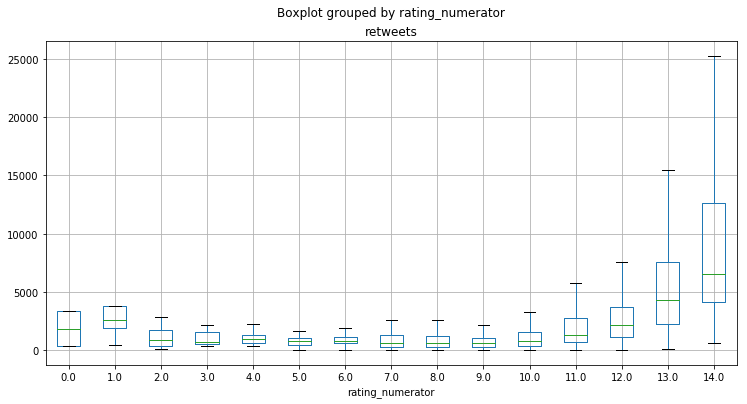

In [51]:
# outliers omitted from the boxplots for better readibility

df.boxplot(by = 'rating_numerator', column = 'retweets', figsize = (12,6), showfliers = False)

/home/mailjo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


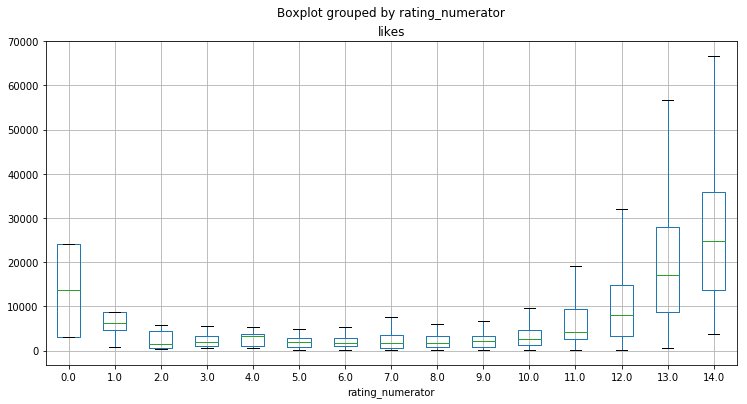

In [52]:
df.boxplot(by = 'rating_numerator', column = 'likes', figsize = (12,6), showfliers = False)